Implementing Metropolis-Hastings

Let's implement the Metropolis-Hastings algorithm to sample from a standard normal distribution.

<>:65: SyntaxWarning: invalid escape sequence '\m'
<>:65: SyntaxWarning: invalid escape sequence '\m'
C:\Users\ME-PC\AppData\Local\Temp\ipykernel_11728\1274623618.py:65: SyntaxWarning: invalid escape sequence '\m'
  ax.plot(x, normal_distribution(x), label="Standard Normal Distribution $\mathcal{N}(0, 1)$", color='r')


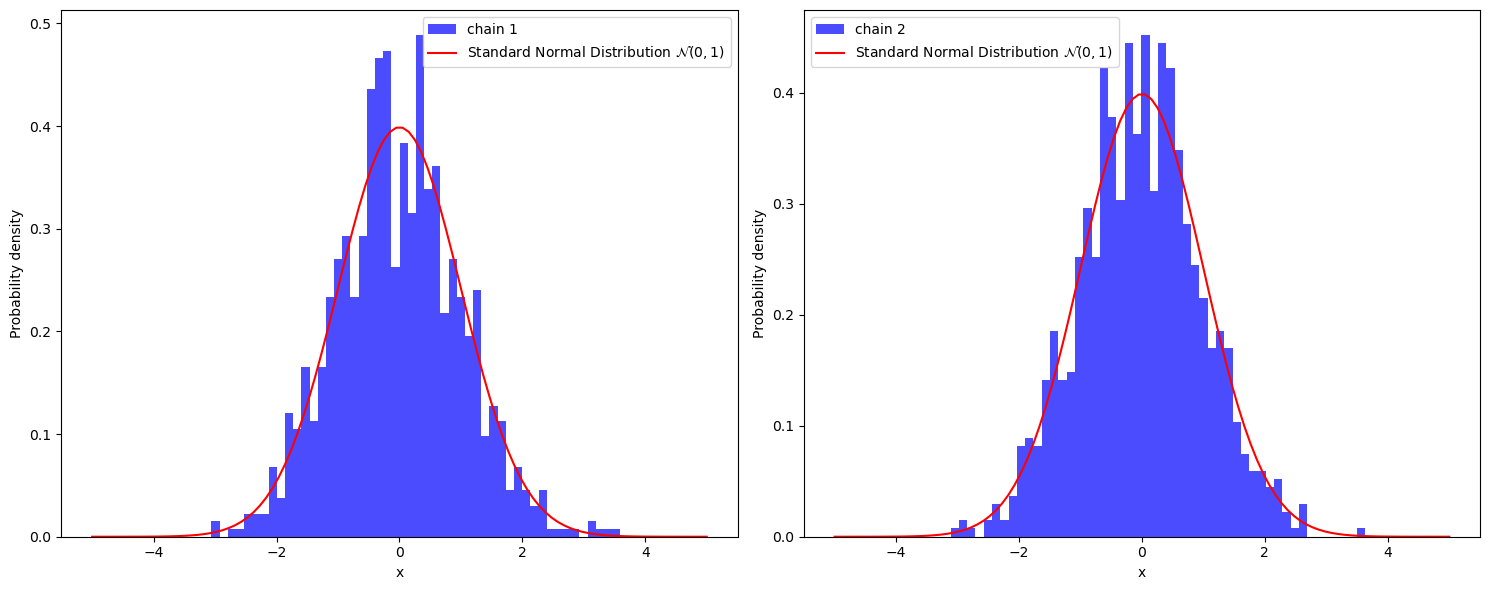

Acceptance ratios: [0.6052, 0.6121]
Means of processed chains: [-0.01145868983280618, -0.02072568178979506]


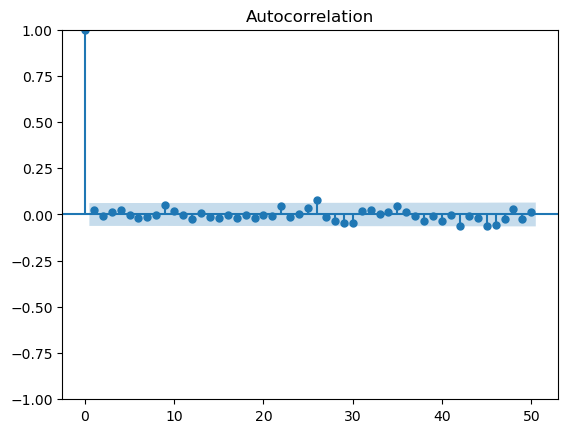

In [10]:
import numpy as np
import matplotlib.pyplot as plt

def normal_distribution(x):
  return np.exp(-0.5 * x**2) / np.sqrt(2 * np.pi)

def mh_mcmc(target, initial_state, n_steps, step_size):
  current = initial_state
  chain = np.zeros(n_steps)
  chain[0] = current
  accept = 0

  for i in range(1, n_steps):
    proposed = current + np.random.normal(0, step_size)
    u = np.random.uniform(0, 1)
    R = target(proposed) / target(current)

    if u < min(1, R):
      current = proposed
      accept += 1

    chain[i] = current

  return chain, accept/n_steps

def run_multiple_chains(initial_states, n_steps, step_size, target):
  chains = []
  acceptance_rates = []

  for initial_state in initial_states:
    chain, acceptance_rate = mh_mcmc(target, initial_state, n_steps, step_size)
    chains.append(chain)
    acceptance_rates.append(acceptance_rate)

  return chains, acceptance_rates

# Initial parameters
initial_states = [-0.3, 2]
n_steps = 10000
step_size = 1.4
k = 10 # Thinning interval
x = np.linspace(-5, 5, 100)

# Run multiple chains
chains, acceptance_rates = run_multiple_chains(initial_states, n_steps, step_size, normal_distribution)

# Process chains (Burn-in + Thinning)
burn = int(0.15*len(chains)) # chain=[0 1 ... burn ... end]
processed_chains = []

for chain in chains:
  # Burn-in
  burned_chain = chain[burn:] # sequence[start:end]

  #Thinning
  thinned_chain = burned_chain[::k] # sequence[::step]=sequence[start:end:step]
  processed_chains.append(thinned_chain)


#Plotting
fig, axes = plt.subplots(1, len(processed_chains), figsize=(15, 6))

for i, (chain, ax) in enumerate(zip(processed_chains, axes)):
  ax.hist(chain, bins=50, density=True, alpha=0.7, color='b', label=f"chain {i+1}")
  ax.plot(x, normal_distribution(x), label="Standard Normal Distribution $\mathcal{N}(0, 1)$", color='r')
  ax.set_xlabel("x")
  ax.set_ylabel("Probability density")
  ax.legend()

plt.tight_layout()  
plt.show()

print(f'Acceptance ratios: {acceptance_rates}')

# Convergence
means = [np.mean(chain) for chain in processed_chains]
print(f"Means of processed chains: {means}")

from statsmodels.graphics.tsaplots import plot_acf
plot_acf(chain, lags=50)  # You can adjust the number of lags
plt.show()


Multivariate Metropolis-Hastings

The Metropolis-Hastings algorithm can be extended to sample from multivariate distributions.

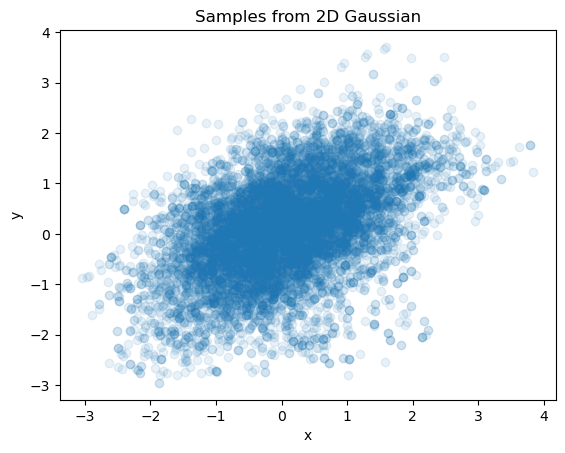

In [23]:
import numpy as np
import matplotlib.pyplot as plt

def multivariate_target(x):
    return np.exp(-0.5 * (x[0]**2 + x[1]**2 - 2*0.5*x[0]*x[1]) / (1 - 0.5**2))

def multivariate_proposal(x, cov):
    return np.random.multivariate_normal(x, cov)

def multivariate_metropolis_hastings(num_samples, cov):
    samples = np.zeros((num_samples, 2))
    current = np.zeros(2)
    
    for i in range(num_samples):
        proposed = multivariate_proposal(current, cov)
        if np.random.random() < min(1, multivariate_target(proposed) / multivariate_target(current)):
            current = proposed
        samples[i] = current
    
    return samples

cov = np.array([[0.1, 0], [0, 0.1]])
samples = multivariate_metropolis_hastings(10000, cov)

#plt.figure(figsize=(10, 10))
plt.scatter(samples[:, 0], samples[:, 1], alpha=0.1)
plt.title("Samples from 2D Gaussian")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

Real-life Example: Estimating Parameters of a Mixture Model

Let's use Metropolis-Hastings to estimate the parameters of a mixture of two Gaussian distributions.

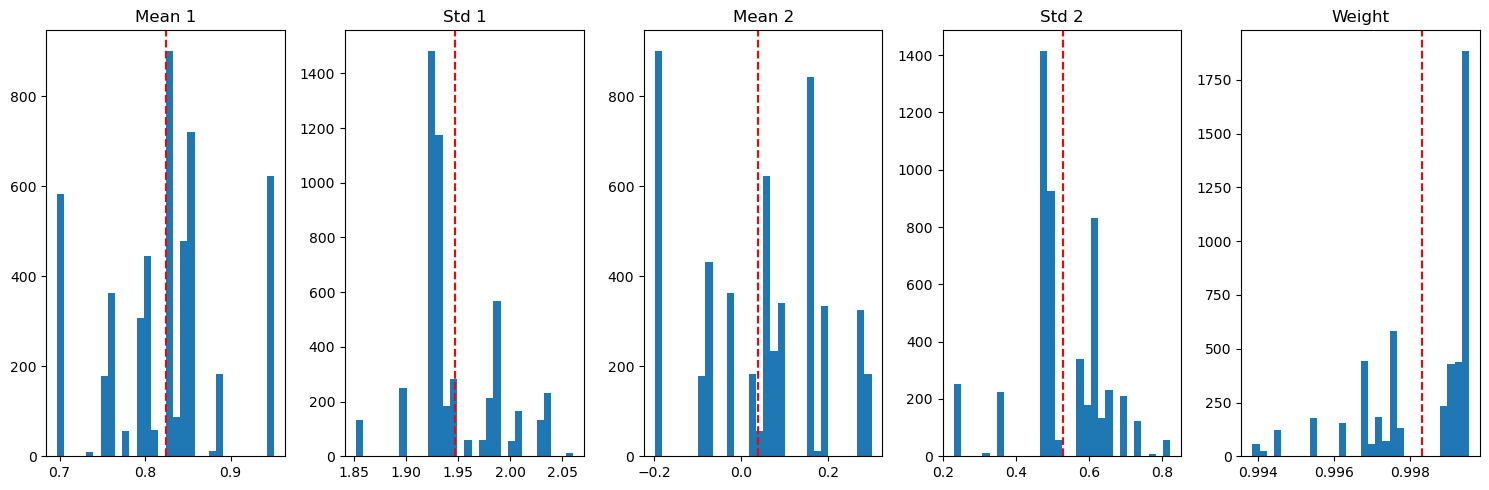

Estimated parameters:
[0.82395925 1.94688595 0.03863323 0.52850315 0.99829699]
True parameters:
[-2, 2, 1, 0.5, 0.3]


In [17]:
import numpy as np
import matplotlib.pyplot as plt

# Generate data from a mixture of two Gaussians
np.random.seed(42)
n_samples = 1000
true_means = [-2, 2]
true_stds = [1, 0.5]
true_weights = [0.3, 0.7]

data = np.concatenate([
    np.random.normal(true_means[0], true_stds[0], int(n_samples * true_weights[0])),
    np.random.normal(true_means[1], true_stds[1], int(n_samples * true_weights[1]))
])

# Define the log-likelihood function
def log_likelihood(params, data):
    mean1, std1, mean2, std2, weight = params
    
    # Ensure parameters are within valid ranges
    if std1 <= 0 or std2 <= 0 or weight <= 0 or weight >= 1:
        return -np.inf
    
    mix1 = weight * np.exp(-0.5 * ((data - mean1) / std1)**2) / (std1 * np.sqrt(2 * np.pi))
    mix2 = (1 - weight) * np.exp(-0.5 * ((data - mean2) / std2)**2) / (std2 * np.sqrt(2 * np.pi))
    
    return np.sum(np.log(mix1 + mix2))

# Metropolis-Hastings algorithm
def metropolis_hastings(data, num_iterations):
    current_params = np.array([0, 1, 0, 1, 0.5])  # Initial guess
    current_ll = log_likelihood(current_params, data)
    samples = [current_params]
    
    for _ in range(num_iterations):
        proposed_params = current_params + np.random.normal(0, 0.1, 5)
        proposed_ll = log_likelihood(proposed_params, data)
        
        if np.random.random() < np.exp(proposed_ll - current_ll):
            current_params = proposed_params
            current_ll = proposed_ll
        
        samples.append(current_params)
    
    return np.array(samples)

# Run the algorithm
samples = metropolis_hastings(data, 10000)

# Plot results
plt.figure(figsize=(15, 5))
param_names = ['Mean 1', 'Std 1', 'Mean 2', 'Std 2', 'Weight']
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.hist(samples[5000:, i], bins=30)
    plt.title(param_names[i])
    plt.axvline(samples[5000:, i].mean(), color='r', linestyle='--')
plt.tight_layout()
plt.show()

print("Estimated parameters:")
print(samples[5000:].mean(axis=0))
print("True parameters:")
print(true_means + true_stds + [true_weights[0]])

Real-life Example: Image Denoising

Let's use Metropolis-Hastings for image denoising, assuming a simple prior distribution on pixel intensities.

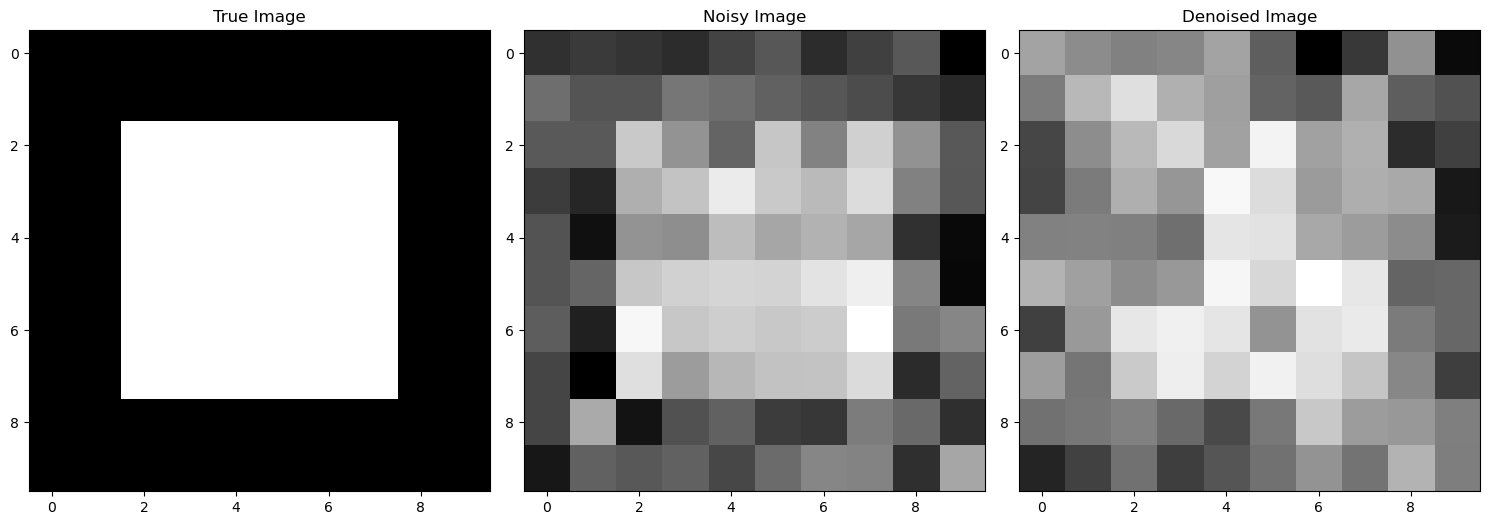

In [21]:
import numpy as np
import matplotlib.pyplot as plt

# Create a simple 10x10 image
true_image = np.zeros((10, 10))
true_image[2:8, 2:8] = 1

# Add noise
noisy_image = true_image + np.random.normal(0, 0.3, true_image.shape)

# Define the log-posterior (combining likelihood and prior)
def log_posterior(image, noisy_image, beta):
    likelihood = -0.5 * np.sum((image - noisy_image)**2)
    
    # Prior term with fixed broadcasting issue
    prior = -beta * (
        np.sum(np.abs(np.diff(image, axis=0))) +    # Difference along rows
        np.sum(np.abs(np.diff(image, axis=1)))       # Difference along columns
    )
    return likelihood + prior

# Metropolis-Hastings for image denoising
def denoise_image(noisy_image, num_iterations, beta):
    current_image = np.array(noisy_image)
    current_log_post = log_posterior(current_image, noisy_image, beta)
    
    for _ in range(num_iterations):
        i, j = np.random.randint(0, noisy_image.shape[0]), np.random.randint(0, noisy_image.shape[1])
        proposed_image = np.array(current_image)
        proposed_image[i, j] += np.random.normal(0, 0.1)
        
        proposed_log_post = log_posterior(proposed_image, noisy_image, beta)
        
        if np.random.random() < np.exp(proposed_log_post - current_log_post):
            current_image = proposed_image
            current_log_post = proposed_log_post
    
    return current_image

# Run the denoising algorithm
denoised_image = denoise_image(noisy_image, 10000, beta=1.0)

# Plot results
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(true_image, cmap='gray')
axes[0].set_title("True Image")
axes[1].imshow(noisy_image, cmap='gray')
axes[1].set_title("Noisy Image")
axes[2].imshow(denoised_image, cmap='gray')
axes[2].set_title("Denoised Image")
plt.tight_layout()
plt.show()
